In [1]:
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import pandas as pd



In [2]:
df = pd.read_csv('text_emotion.csv')

In [3]:
df.head(10)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ..."
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?


It looks like there are lots of different characters, creative spelling and punctuation, misspellings, slang, new words or URLs. This needs to be fixed

## DATA WRANGLING, VISUALIZATION

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


There are no empty rows 

Lets see the group of sentiments on a graph

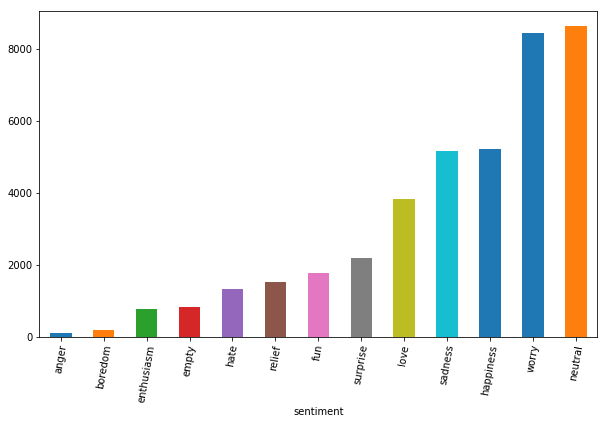

In [5]:
plt.subplots(figsize=(10,6))

df.groupby('sentiment')['content'].count().sort_values(ascending=True).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [6]:
df.describe(include='object')

,sentiment,author,content
count,40000,40000,40000
unique,13,33871,39827
top,neutral,MissxMarisa,I just received a mothers day card from my lov...
freq,8638,23,14


In [7]:
df.isnull().sum()

tweet_id     0
sentiment    0
author       0
content      0
dtype: int64

No missing values

In [8]:
df.duplicated().sum()

0

No duplicate values

Now lets see the distribution of emotions in the data set

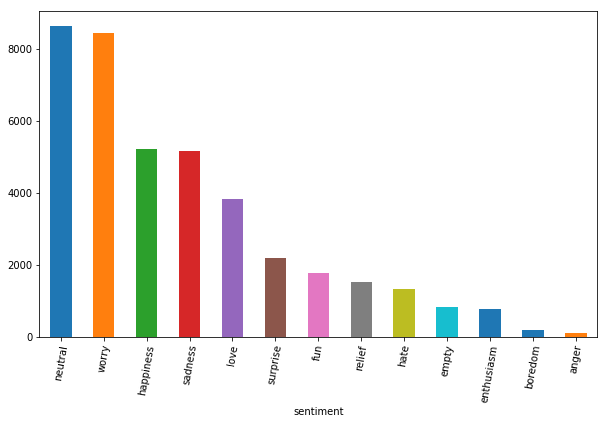

In [9]:
plt.subplots(figsize=(10,6))

df.groupby('sentiment')['content'].count().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [13]:
import sys
!{sys.executable} -m pip install -U spacy


Requirement already up-to-date: spacy in /anaconda3/lib/python3.7/site-packages (2.1.8)


In [14]:
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

In [17]:
# spacy_tok = spacy.load('en')
# sample_review=df.context[10]
# sample_review

In [18]:
df.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64